In [1]:
from data import load_data, data_prep
from train import train, objective, build_hidden_mults
from data_openml import DataSetCatCon
from torch.utils.data import DataLoader
from models import SAINT
import torch.optim as optim
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import pandas as pd
import optuna
import numpy as np
import torch
from optuna.exceptions import TrialPruned
import os
import pickle

##################################
MAX_FEATURES=180
N_TRIALS= 20     
N_ROWS = None    # Set to None to use all rows
BS = 16
##################################

X, y = load_data(n_rows=N_ROWS)

#========> Set a random seed for reproducibility
np.random.seed(239048)
cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, continuous_mean_std = data_prep(X, y, datasplit=[.65, .15, .2])


/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check if the following file exists.
filename = f"fgps_selector-{MAX_FEATURES}.pkl"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        fgpts_selector = pickle.load(f)
else:
    # select best fingerprints 
    X_catboost = pd.DataFrame(X_train["data"])
    categorical_columns = [X_catboost.columns[i] for i in cat_idxs]
    for col in categorical_columns:
        X_catboost[col] = X_catboost[col].astype("int")
    model2 = CatBoostRegressor(cat_features=cat_idxs) 
    #================> should use only train data to avoid data leakage
    model2.fit(X_catboost, y_train["data"])
    #==================> To only select based on max_features, set threshold=-np.inf.
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
    fgpts_selector = SelectFromModel(model2, prefit=True, threshold=-np.inf, max_features=MAX_FEATURES)
    with open(filename, "wb") as f:
        pickle.dump(fgpts_selector, f)


In [3]:
features_mask = fgpts_selector.get_support()
# Force that both m/z and adduct are always selected 
features_mask[0] = True
features_mask[1] = True
# Ensure m/z is always selected
assert features_mask[0] == True
# Ensure adduct is always selected
assert features_mask[1] == True

n_features = X_train["data"][:, features_mask].shape[1]

cat_idxs = list(range(1, n_features))
print(cat_idxs)
cat_dims = cat_dims[:n_features]
print(cat_dims)

X_train["data"] = X_train["data"][:, features_mask]
X_train["mask"] = X_train["mask"][:, features_mask]
X_valid["data"] = X_valid["data"][:, features_mask]
X_valid["mask"] = X_valid["mask"][:, features_mask]
X_test["data"] = X_test["data"][:, features_mask]
X_test["mask"] = X_test["mask"][:, features_mask]



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
[1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [4]:
train_ds = DataSetCatCon(X_train, y_train, cat_idxs,'reg',continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=BS, shuffle=True,num_workers=4)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs,'reg', continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=BS, shuffle=False,num_workers=4)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,'reg', continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=BS, shuffle=False,num_workers=4)

In [5]:
# select best hyperparameters

storage_name = "sqlite:///saint.db"
study1 = optuna.create_study(study_name=f"MF_{MAX_FEATURES}_step-1", storage=storage_name, load_if_exists=True, pruner=optuna.pruners.NopPruner())

already_done = len([trial for trial in study1.trials if trial.state == optuna.trial.TrialState.COMPLETE])


[I 2024-06-28 12:56:13,213] Using an existing study with name 'MF_180_step-1' instead of creating a new one.


In [6]:
n_trials_to_do = N_TRIALS - already_done
if n_trials_to_do > 0:
    study1.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, first_trial=True), n_trials=n_trials_to_do, catch=(Exception, ))

optim_params1 = study1.best_params 

lr = optim_params1['lr']
wd = optim_params1['weight_decay']
epochs = optim_params1['epochs']

In [7]:
# Create an unique id for step-2 based on the best hyperparameters from step-1
# unique_id = hash("{}-{}".format(str(lr), str(wd), str(epochs)))

unique_id = hash("{}-{}-{}".format(str(lr), str(wd), str(epochs)))
study = optuna.create_study(
    study_name=f"MF_{MAX_FEATURES}_id_{unique_id}_step-2c",
    storage=storage_name,
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=10, reduction_factor=3
    ),
    load_if_exists=True
)

study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))


[I 2024-06-28 12:56:13,397] A new study created in RDB with name: MF_180_id_6579809149785645258_step-2c


lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 45, depth: 1, heads: 7, attn_dropout: 0.22171703538357104, ff_dropout: 0.7955888435904183, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 12:56:22,254] Trial 0 failed with parameters: {'dim': 45, 'depth': 1, 'heads': 7, 'attn_dropout': 0.22171703538357104, 'ff_dropout': 0.7955888435904183, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 1.98 GiB (GPU 0; 11.75 GiB total capacity; 9.18 GiB already allocated; 867.62 MiB free; 9.20 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File 

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 35, depth: 2, heads: 5, attn_dropout: 0.21459832928096959, ff_dropout: 0.16146670728870777, mlp_hidden_mults: (4, 2), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 12:56:29,155] Trial 1 failed with parameters: {'dim': 35, 'depth': 2, 'heads': 5, 'attn_dropout': 0.21459832928096959, 'ff_dropout': 0.16146670728870777, 'mlp_hidden_mults': 4, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 1.20 GiB (GPU 0; 11.75 GiB total capacity; 9.19 GiB already allocated; 130.75 MiB free; 9.95 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  F

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 24, depth: 1, heads: 5, attn_dropout: 0.40415341749482925, ff_dropout: 0.40305917353179344, mlp_hidden_mults: (8, 4), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 10/10 [19:19<00:00, 116.00s/it]
[I 2024-06-28 13:15:51,122] Trial 2 finished with value: 17.284272956848145 and parameters: {'dim': 24, 'depth': 1, 'heads': 5, 'attn_dropout': 0.40415341749482925, 'ff_dropout': 0.40305917353179344, 'mlp_hidden_mults': 8, 'final_mlp_style': 'common'}. Best is trial 2 with value: 17.284272956848145.


lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 57, depth: 1, heads: 8, attn_dropout: 0.8202072362401538, ff_dropout: 0.375388056793699, mlp_hidden_mults: (16, 8), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 13:16:03,446] Trial 3 failed with parameters: {'dim': 57, 'depth': 1, 'heads': 8, 'attn_dropout': 0.8202072362401538, 'ff_dropout': 0.375388056793699, 'mlp_hidden_mults': 16, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 3.17 GiB (GPU 0; 11.75 GiB total capacity; 9.51 GiB already allocated; 716.00 MiB free; 9.54 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File "

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 52, depth: 1, heads: 8, attn_dropout: 0.8370557256957373, ff_dropout: 0.6510743432523631, mlp_hidden_mults: (8, 4), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 13:16:12,468] Trial 4 failed with parameters: {'dim': 52, 'depth': 1, 'heads': 8, 'attn_dropout': 0.8370557256957373, 'ff_dropout': 0.6510743432523631, 'mlp_hidden_mults': 8, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 2.64 GiB (GPU 0; 11.75 GiB total capacity; 7.09 GiB already allocated; 2.29 GiB free; 7.95 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File 

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 44, depth: 1, heads: 4, attn_dropout: 0.5102431475951822, ff_dropout: 0.8445386483478609, mlp_hidden_mults: (16, 8), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 13:16:20,022] Trial 5 failed with parameters: {'dim': 44, 'depth': 1, 'heads': 4, 'attn_dropout': 0.5102431475951822, 'ff_dropout': 0.8445386483478609, 'mlp_hidden_mults': 16, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 1.89 GiB (GPU 0; 11.75 GiB total capacity; 9.49 GiB already allocated; 227.44 MiB free; 10.02 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 44, depth: 1, heads: 5, attn_dropout: 0.5954818649615975, ff_dropout: 0.8131209799202824, mlp_hidden_mults: (16, 8), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 13:16:27,348] Trial 6 failed with parameters: {'dim': 44, 'depth': 1, 'heads': 5, 'attn_dropout': 0.5954818649615975, 'ff_dropout': 0.8131209799202824, 'mlp_hidden_mults': 16, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 1.89 GiB (GPU 0; 11.75 GiB total capacity; 7.62 GiB already allocated; 212.19 MiB free; 10.02 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  F

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 24, depth: 2, heads: 5, attn_dropout: 0.7616334662203074, ff_dropout: 0.3812765630245043, mlp_hidden_mults: (16, 8), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


 10%|█         | 1/10 [06:51<1:01:43, 411.50s/it]
[I 2024-06-28 13:23:22,501] Trial 7 pruned. 


lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 16, depth: 2, heads: 6, attn_dropout: 0.46516521858652504, ff_dropout: 0.3706044843550712, mlp_hidden_mults: (8, 4), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 10/10 [19:59<00:00, 119.99s/it]
[I 2024-06-28 13:43:24,066] Trial 8 finished with value: 16.738755416870116 and parameters: {'dim': 16, 'depth': 2, 'heads': 6, 'attn_dropout': 0.46516521858652504, 'ff_dropout': 0.3706044843550712, 'mlp_hidden_mults': 8, 'final_mlp_style': 'common'}. Best is trial 8 with value: 16.738755416870116.


lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 54, depth: 1, heads: 8, attn_dropout: 0.43018470507516215, ff_dropout: 0.645025092966387, mlp_hidden_mults: (8, 4), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 13:43:33,523] Trial 9 failed with parameters: {'dim': 54, 'depth': 1, 'heads': 8, 'attn_dropout': 0.43018470507516215, 'ff_dropout': 0.645025092966387, 'mlp_hidden_mults': 8, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 2.85 GiB (GPU 0; 11.75 GiB total capacity; 7.65 GiB already allocated; 1.97 GiB free; 8.13 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File "/h

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 30, depth: 2, heads: 6, attn_dropout: 0.5342880651214797, ff_dropout: 0.5275458090085285, mlp_hidden_mults: (16, 8), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 13:43:39,180] Trial 10 failed with parameters: {'dim': 30, 'depth': 2, 'heads': 6, 'attn_dropout': 0.5342880651214797, 'ff_dropout': 0.5275458090085285, 'mlp_hidden_mults': 16, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 900.00 MiB (GPU 0; 11.75 GiB total capacity; 9.00 GiB already allocated; 671.69 MiB free; 9.44 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
 

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 23, depth: 2, heads: 4, attn_dropout: 0.2819413093881771, ff_dropout: 0.13257030385772506, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 10/10 [32:04<00:00, 192.43s/it]
[I 2024-06-28 14:15:46,441] Trial 11 finished with value: 16.96507873535156 and parameters: {'dim': 23, 'depth': 2, 'heads': 4, 'attn_dropout': 0.2819413093881771, 'ff_dropout': 0.13257030385772506, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep'}. Best is trial 8 with value: 16.738755416870116.


lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 62, depth: 1, heads: 4, attn_dropout: 0.8738444420973446, ff_dropout: 0.4904913984236493, mlp_hidden_mults: (4, 2), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:15:58,100] Trial 12 failed with parameters: {'dim': 62, 'depth': 1, 'heads': 4, 'attn_dropout': 0.8738444420973446, 'ff_dropout': 0.4904913984236493, 'mlp_hidden_mults': 4, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 3.75 GiB (GPU 0; 11.75 GiB total capacity; 9.58 GiB already allocated; 572.75 MiB free; 9.73 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  Fi

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 43, depth: 1, heads: 4, attn_dropout: 0.26456241205383113, ff_dropout: 0.6958103945048455, mlp_hidden_mults: (8, 4), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:16:04,179] Trial 13 failed with parameters: {'dim': 43, 'depth': 1, 'heads': 4, 'attn_dropout': 0.26456241205383113, 'ff_dropout': 0.6958103945048455, 'mlp_hidden_mults': 8, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 1.81 GiB (GPU 0; 11.75 GiB total capacity; 8.49 GiB already allocated; 1.12 GiB free; 9.16 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  Fil

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 27, depth: 1, heads: 3, attn_dropout: 0.3222920202380187, ff_dropout: 0.8551979073315564, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


 90%|█████████ | 9/10 [22:15<02:28, 148.38s/it]
[I 2024-06-28 14:38:21,914] Trial 14 pruned. 


lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 50, depth: 1, heads: 2, attn_dropout: 0.49966539061443305, ff_dropout: 0.5534495065014647, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:38:29,737] Trial 15 failed with parameters: {'dim': 50, 'depth': 1, 'heads': 2, 'attn_dropout': 0.49966539061443305, 'ff_dropout': 0.5534495065014647, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 2.44 GiB (GPU 0; 11.75 GiB total capacity; 8.69 GiB already allocated; 1.15 GiB free; 9.16 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File "

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 39, depth: 1, heads: 8, attn_dropout: 0.3515793605575398, ff_dropout: 0.5724657931708903, mlp_hidden_mults: (8, 4), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:38:34,849] Trial 16 failed with parameters: {'dim': 39, 'depth': 1, 'heads': 8, 'attn_dropout': 0.3515793605575398, 'ff_dropout': 0.5724657931708903, 'mlp_hidden_mults': 8, 'final_mlp_style': 'common'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 1.49 GiB (GPU 0; 11.75 GiB total capacity; 7.11 GiB already allocated; 1.15 GiB free; 9.15 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 31, depth: 2, heads: 2, attn_dropout: 0.261202037248282, ff_dropout: 0.8790505891503672, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:38:40,125] Trial 17 failed with parameters: {'dim': 31, 'depth': 2, 'heads': 2, 'attn_dropout': 0.261202037248282, 'ff_dropout': 0.8790505891503672, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 962.00 MiB (GPU 0; 11.75 GiB total capacity; 9.97 GiB already allocated; 222.12 MiB free; 10.10 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  Fil

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 53, depth: 1, heads: 3, attn_dropout: 0.6701974708296727, ff_dropout: 0.3974650020829573, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:38:48,654] Trial 18 failed with parameters: {'dim': 53, 'depth': 1, 'heads': 3, 'attn_dropout': 0.6701974708296727, 'ff_dropout': 0.3974650020829573, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 2.74 GiB (GPU 0; 11.75 GiB total capacity; 7.01 GiB already allocated; 211.12 MiB free; 10.11 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  File

lr: 5.613283190233199e-05, weight_decay: 0.04846185144056176, epochs: 10, dim: 48, depth: 2, heads: 2, attn_dropout: 0.7986870512655566, ff_dropout: 0.32132598306568055, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]
[W 2024-06-28 14:39:00,480] Trial 19 failed with parameters: {'dim': 48, 'depth': 2, 'heads': 2, 'attn_dropout': 0.7986870512655566, 'ff_dropout': 0.32132598306568055, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep'} because of the following error: RuntimeError('CUDA out of memory. Tried to allocate 2.25 GiB (GPU 0; 11.75 GiB total capacity; 9.16 GiB already allocated; 263.12 MiB free; 10.06 GiB reserved in total by PyTorch)').
Traceback (most recent call last):
  File "/opt/miniforge3/envs/ccs_pred/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_215226/2583905535.py", line 15, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
  File "/home/carlota/repos/tfg_ccsPrediction/train.py", line 175, in objective
    valid_rmse = train(
  Fil

Using device = cuda:0


100%|██████████| 10/10 [18:49<00:00, 112.90s/it]


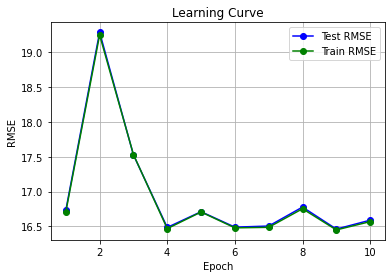

Final test RMSE: 16.95682563781738


In [8]:
optim_params = study.best_params 
optim_params['mlp_hidden_mults'] = build_hidden_mults(optim_params['mlp_hidden_mults'])  

model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),                
    dim = optim_params['dim'],                         
    dim_out = 1,                       
    depth = optim_params['depth'],                        
    heads = optim_params['heads'],                         
    attn_dropout = optim_params['attn_dropout'],             
    ff_dropout = optim_params['ff_dropout'],                  
    mlp_hidden_mults = optim_params['mlp_hidden_mults'],       
    cont_embeddings = 'MLP',
    attentiontype = 'colrow',
    final_mlp_style = optim_params['final_mlp_style'],
    y_dim = 1 # porque es regression 
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device = {device}")
model.to(device)

# ========> we always use the following
optimizer = optim.AdamW(model.parameters(),lr=optim_params1['lr'], weight_decay=optim_params1['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, optim_params1['epochs'])

test_rmse = train(model, optimizer, scheduler, optim_params1["epochs"], trainloader, testloader, plot=True)
print(f"Final test RMSE: {test_rmse}")